In [1]:
import math
import os
import time
from glob import glob
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon import nn, rnn
import spacy

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
from collections import defaultdict

In [3]:
import xml.etree.ElementTree as ET

In [4]:
from functools import reduce
class ArgumentTree(object):
    def __init__(self, value, text=None):
        self.children = []
        self.parent = None
        self.value = value
        self.text = text
    
    def __repr__(self):
        if self.children:
            return '[{}: {}]'.format(self.value, ', '.join([str(c) for c in self.children]))
        else:
            return '{}({})'.format(self.value, self.text)
        
    @property
    def p_value(self):
        if self.parent:
            return self.parent.value
        else:
            return self.value
    
    def __len__(self):
        if self.children:
            return 1 + sum([len(l) for l in self.children])
        else:
            return 0
    
    @property
    def root(self):
        if self.parent is None:
            return self
        else:
            return self.parent.root
    
    def search(self, value):
        if self.value == value:
            return self
        else:
            return next((c for c in (child.search(value) for child in self.children) if c is not None), None)
    
    def add(self, child):
        self.children.append(child)
        child.parent = self

In [5]:
def read_ac(xml):
    arguments = {x.get('id'):x.text for x in xml.findall('edu')}
    edges = [x for x in xml.findall('edge')]

    trees = []
    # parent (major claim) -> child (claims)
    for edge in edges:
        fr = edge.get('src')
        text = arguments.get(fr)
        to = edge.get('trg')
        while to.startswith('c'):
            to = next(edge for edge in edges if edge.get('id') == to).get('trg')

        child = next((node for node in (tree.search(fr) for tree in trees) if node is not None), ArgumentTree(fr, text))
        parent = next((node for node in (tree.search(to) for tree in trees) if node is not None), ArgumentTree(to))

        parent.add(child)
        trees.append(parent)
    return trees[0].root

In [6]:
nlp = spacy.load('en_core_web_lg')

In [7]:
from sklearn.model_selection import ShuffleSplit
class MTCorpus(object):
    def __init__(self):
        files = sorted(glob('./arg-microtexts/corpus/en/*.xml'))
        self.links = []
        self.documents = []
        self.lemmas = defaultdict(int)
        self.tags = defaultdict(int)
        for file in files:
            with open(file,'r',encoding='UTF-8') as file:
                xml = ET.parse(file)
                ac_tree = read_ac(xml)
                y = [int(ac_tree.search('a{}'.format(i)).p_value[1:]) for i in range(1, len(ac_tree) + 1)]
                self.links.append(y)
                x = [ac_tree.search('e{}'.format(i)).text for i in range(1, len(ac_tree) + 1)]
                self.documents.append([])
                for ac in x:
                    self.documents[-1].append(self.represent(ac))
                self.documents[-1] = np.array(self.documents[-1])
        
    '''Tokenizes a string.'''
    def represent(self, sent):
        # Tokenize sentence
        tokens = nlp(sent)
        # lemmas
        for token in tokens:
            self.lemmas[token.lemma_] += 1
            self.tags[token.tag_] += 1
        # Bag of words (with spacy word2vec)
        return np.mean([token.vector for token in tokens], axis=0)

In [8]:
[[0,1,2],]

[[0, 1, 2]]

In [9]:
files = glob('./arg-microtexts/corpus/en/*.xml')
len(files)

112

In [10]:
corpus = MTCorpus()

In [11]:
corpus.documents[0].shape

(5, 300)

In [12]:
corpus.links[0]

[5, 1, 5, 5, 5]

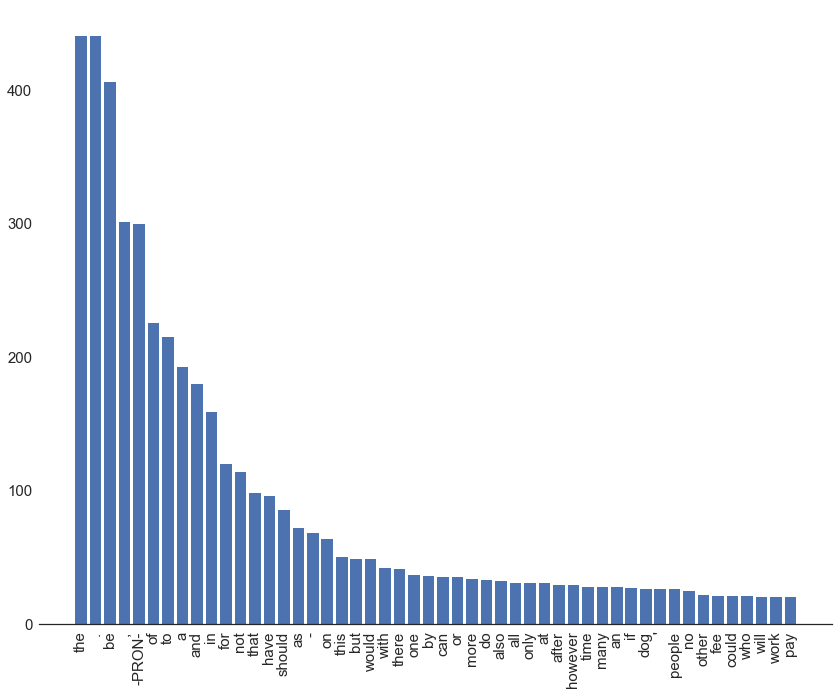

In [13]:
limit = 50
top_lemmas = dict(sorted(corpus.lemmas.items() ,key=lambda x: x[1], reverse=True)[:limit])
sns.set_style("white")
plt.figure(figsize=(12,10))
plt.bar(range(limit), list(top_lemmas.values())[:limit])
plt.xticks(range(limit), list(top_lemmas.keys())[:limit], rotation='vertical')
sns.despine(left=True)
plt.tight_layout();

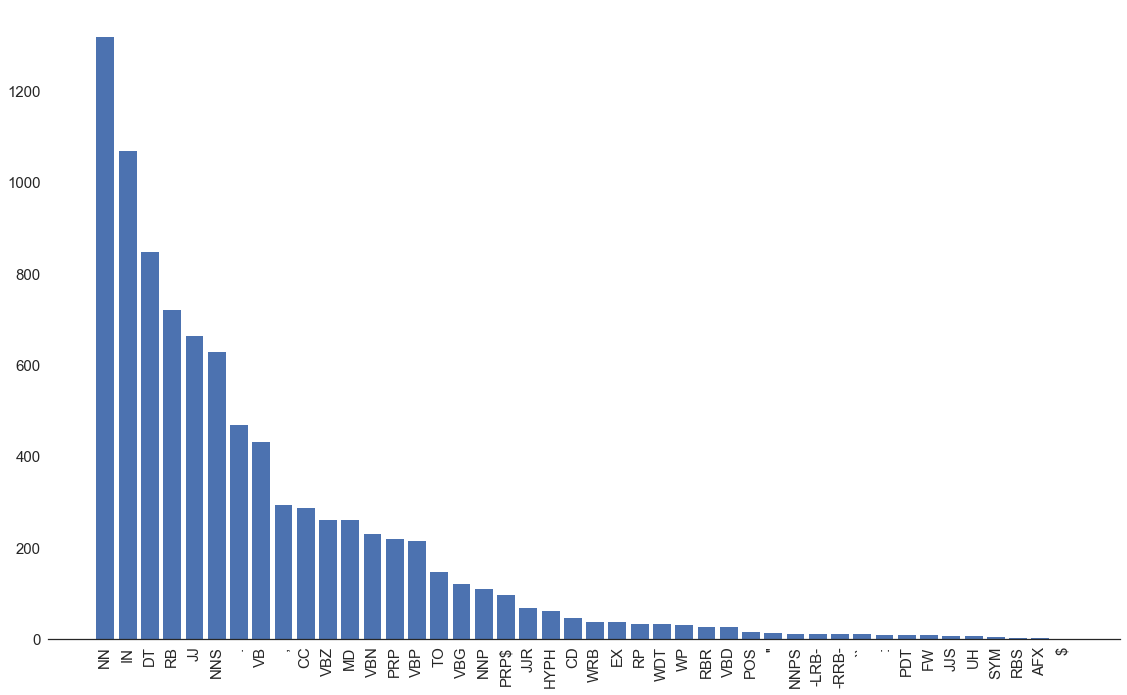

In [14]:
top_tags = dict(sorted(corpus.tags.items() ,key=lambda x: x[1], reverse=True)[:100])
sns.set_style("white")
plt.figure(figsize=(16,10))
plt.bar(range(len(top_tags)), list(top_tags.values())[:100])
plt.xticks(range(len(top_tags)), list(top_tags.keys())[:100], rotation='vertical')
sns.despine(left=True)
plt.tight_layout();